# Application 1: The Quantum Harmonic Oscillator

Contributed by: Daniel Lay, Eric Flynn

The Schrodinger equation for the 1d harmonic oscillator (HO) is usually written as

\begin{align}
H_\alpha\phi(x)\equiv \bigg(-\frac{d^2}{dx^2}+\alpha x^2\bigg)\phi(x)=\lambda\phi(x),\quad \langle\phi|\phi\rangle=1,
\end{align}

where, for comparison with textbooks, the eigenvalue is $\lambda=2mE/\hbar^2$ and the HO parameter is $\alpha=(m\omega/\hbar)^2$. A useful distinction is the kinetic and potential energy terms:

\begin{align}
T\phi(x)=-\frac{d^2}{dx^2}\phi(x),\quad V_\alpha(x)\phi(x)=\alpha x^2\phi(x),\quad H_\alpha(x)=T+V(x).
\end{align}

Technically, all of $T,V_\alpha$, and $H_\alpha$ are operators, but if we discretize our wavefunction (in order to, say, put it on a computer), they are just matrices.


### "Traditional" RBM
To use the traditional RBM approach, one option is to rewrite the Schrodinger equation as

\begin{align}
\bigg(-\frac{d^2}{dx^2}+\alpha x^2-\lambda\bigg)\phi(x)\equiv F_\alpha(\phi(x))=0,
\end{align}

defining the operator $F_\alpha$, and solving the system

\begin{align}
F_\alpha(\phi(x))=0,\quad\langle\phi|\phi\rangle=1.
\end{align}

We then solve this for a set of parameters $\{\alpha_i\}_{i=1}^n$, and for any arbitrary parameter $\alpha_k$, take as our ansatz

\begin{align}
	\hat{\phi}_{\alpha_{k}}(x) = \sum_{i=1}^{n} a_{i} \phi_{i}(x) .
\end{align}

This is a nice form, as it is straightforward to generalize to non-eigenvalue problems. 

In [2]:
import numpy as np
from scipy import special
import scipy
import matplotlib.pyplot as plt
import time
from scipy.optimize import minimize
from scipy.linalg import eigh

In [3]:
def exact_wavefunction(n,alpha):
    """
    Exact wavefunction, from 
    https://en.wikipedia.org/wiki/Quantum_harmonic_oscillator#Hamiltonian_and_energy_eigenstates
    modified for our notation.

    Parameters
    ----------
    n : int
        Order of the solution.
    alpha : float
        The HO parameter.

    Returns
    -------
    wf : function
        The exact wavefunction.

    """
    norm = 1/np.sqrt(2.**n * np.math.factorial(n))*(np.sqrt(alpha)/np.pi)**(1/4)
    herm = special.hermite(n)
    def wf(x):
        return norm*np.exp(-np.sqrt(alpha)*x**2/2)*herm(x)
    return wf

def exact_eigenvalue(n,alpha):
    """
    Exact eigenvalue $\lambda$ of the ODE
    
    $$ -f''(x) + alpha x^2f(x) = \lambda f(x) $$
    
    We assume throughout that $m = \hbar = 1$. Then, $\lambda$ is related to the
    energy as $\lambda = 2E$.

    Parameters
    ----------
    n : int
        Order of the solution.
    alpha : float
        The HO parameter.

    Returns
    -------
    float
        The eigenvalue.

    """
    
    return np.sqrt(alpha)*(n+0.5)

class FiniteDifferenceSolver:
    def __init__(self,alpha,regularGrid,h):
        self.alpha = alpha
        self.grid = regularGrid
        
        self.H = self.make_Hamiltonian_matrix()
        
    def make_kinetic_term(self):
        size = len(self.grid)
        offDiag = np.zeros(size)
        offDiag[1] = 1
        
        #Kinetic term
        H = -1*(-2*np.identity(size) + scipy.linalg.toeplitz(offDiag))/h**2
        return H
        
    def make_potential_term(self):
        H = np.diag(self.alpha*self.grid**2)
        return H
        
    def make_Hamiltonian_matrix(self):
        return self.make_kinetic_term() + self.make_potential_term()
    
    def solve(self):
        t0 = time.time()
        evals, evects = eigh(self.H,subset_by_index=[0,0])
        # evals, evects = np.linalg.eigh(self.H)
                    
        t1 = time.time()
        
        solveTime = t1 - t0
        return evals, evects, solveTime

In [4]:
h = 10**(-2) ### grid spacing for domain (Warning around 10**(-3) it starts to get slow).
### HO global parameters 
n = 0 # principle quantum number to solve in HO
# define the domain boundaries
xLims = [-10,10]
grid = np.arange(xLims[0],xLims[1]+h,h)
m = len(grid)
print('Number of grid points: ',m)
nRepeatsForTiming = 250

# Select alpha values to use to solve SE exactly.
alphaVals = [.5,2,5,7,10,15]

Number of grid points:  2001


### A Slight Reformulation

Because we are solving an eigenvalue problem, we can arrive at a set of different-looking equations, using the same set of judges $\{\psi_i(x)\}_{i=1}^n$ as before. We can simply plug $\hat{\phi}_{\alpha_k}$ into the Schrodinger equation and project both sides onto the judges, writing

\begin{align}
\sum_{i=1}^na_i\langle \psi_j|H_{\alpha_k}|\phi_i\rangle=\lambda\sum_{i=1}^na_i\langle\psi_j|\phi_i\rangle.
\end{align}

Define now two matrices:

\begin{align}
M_{ij}(\alpha)\equiv \langle\psi_j|H_\alpha|\phi_i\rangle,\quad N_{ij}\equiv\langle\psi_j|\phi_i\rangle.
\end{align}

These are both $n\times n$ matrices, and we now have a generalized eigenvalue problem for $\vec{a}$:

\begin{align}
M(\alpha)\vec{a}=\lambda N\vec{a}.
\end{align}

Situationally, this may be quicker to solve than finding the roots of the nonlinear system that results from the "traditional" RBM approach.

As with traditional RBM approaches, this is only helpful if we can evaluate $M(\alpha)$ quickly for different $\alpha$ values. For the HO, this is not too hard: we can write

\begin{align}
\langle\psi_j|H_\alpha|\phi_i\rangle=\langle\psi_j|T|\phi_i\rangle+\alpha\langle \psi_j|x^2|\phi_i\rangle\equiv M_{ij}^{(0)}+\alpha M_{ij}^{(1)}.
\end{align}

Our eigenvalue equation is then

\begin{align}
[M^{(0)}+\alpha M^{(1)}]\vec{a}=\lambda N\vec{a},
\end{align}

and all of $M^{(0)},M^{(1)}$ and $N$ can be precomputed.

As one would hope, this reproduces the exact same results as the "traditional" RBM approach. A code implementation is given below.

In [46]:
class StandardRBM:
    def __init__(self,psiMat,kineticTerm,potentialTerm,judges=None):
        #potentialTerm should not be multiplied by alpha
        self.psiMat = psiMat
        if judges is None:
            self.judges = psiMat
        else:
            self.judges = judges
        self.kineticTerm = kineticTerm
        self.potentialTerm = potentialTerm
        self.matrixDim = psiMat.shape[0]
        
        self.kinProj, self.potProj = self.compute_projections()
        self.overlaps = self.compute_overlaps()
        
    def compute_projections(self):
        kinProj = np.zeros(2*(self.matrixDim,))
        potProj = np.zeros(2*(self.matrixDim,))
        for i in range(self.matrixDim):
            for j in range(i,self.matrixDim):
                kinProj[i,j] = self.judges[i] @ self.kineticTerm @ self.psiMat[j]
                kinProj[j,i] = kinProj[i,j]
                
                potProj[i,j] = self.judges[i] @ self.potentialTerm @ self.psiMat[j]
                potProj[j,i] = potProj[i,j]
                    
        return kinProj, potProj
    
    def compute_overlaps(self):
        overlapMatrix = np.zeros(2*(self.matrixDim,))
        for i in range(self.matrixDim):
            for j in range(i,self.matrixDim):
                overlapMatrix[i,j] = self.judges[i] @ self.psiMat[j]
                overlapMatrix[j,i] = overlapMatrix[i,j]
        return overlapMatrix
        
    def return_wf(self,a):
        return a @ self.psiMat / np.linalg.norm(a @ self.psiMat)

    def solve(self,alpha):
        mat = self.kinProj + alpha*self.potProj
            
        vals, vecs = eigh(mat,b=self.overlaps,check_finite=False)

        return vals[0], vecs[:,0]   


Finite Difference time: 1.493e+00 s
Finite Difference relative error: 3.423e-06
Standard RBM time: 2.399e-05 s
RBM relative error: 7.248e-05


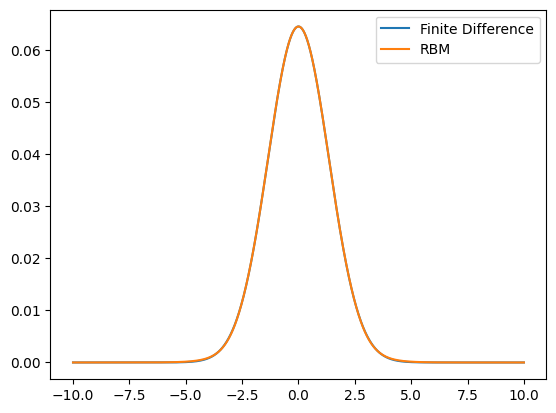

In [47]:
T = np.zeros((len(alphaVals),m)) 

#Getting high-fidelity solutions
for i,alpha in enumerate(alphaVals):
    fdSolver = FiniteDifferenceSolver(alpha,grid,h)
    evals, evecs, runTime = fdSolver.solve()
    kinTerm = fdSolver.make_kinetic_term()
    potTerm = fdSolver.make_potential_term()/alpha
    T[i] = evecs[:,n]

fig, ax = plt.subplots()

alphaTest = 0.3

exactEigenvalue = 2*exact_eigenvalue(n,alphaTest)

#Solving with finite difference
fdSol = FiniteDifferenceSolver(alphaTest,grid,h)
t0 = time.time()
evals, evecs, _ = fdSol.solve()
t1 = time.time()
print('Finite Difference time: %.3e s'%(t1-t0))

err = abs(((evals[0]-exactEigenvalue)/exactEigenvalue))
print('Finite Difference relative error: %.3e'%err)

ax.plot(grid,evecs[:,0],label='Finite Difference')

#Solving with RBM
rbm = StandardRBM(T,kinTerm,potTerm)
t0 = time.time()
for _ in range(nRepeatsForTiming):
    val,  a = rbm.solve(alphaTest)

t1 = time.time()
wf = rbm.return_wf(a)
runTime = (t1-t0)/nRepeatsForTiming
print('Standard RBM time: %.3e s'%runTime)
print('RBM relative error: %.3e'%((val-exactEigenvalue)/exactEigenvalue))

ax.plot(grid,wf,label='RBM')

ax.legend()

### Variational RBM
For many physicists, the first thing to try is the variational approach to solving the Schrodinger equation. We can attempt the same thing, except using the expansion coefficients $\vec{a}$ as variational coefficients. This, as far as I am aware, is what is known as "eigenvector continuation," although different people mean different things when mentioning eigenvector continuation. In general, the variational energy is

\begin{align}
	E_\alpha(\vec{a})=\frac{\langle \phi_{\vec{a}}|H_\alpha|\phi_{\vec{a}}\rangle}{\langle \phi_{\vec{a}}|\phi_{\vec{a}}\rangle},
\end{align}

and by minimizing this energy with respect to the parameters $\vec{a}$, we approximate the ground state energy. 

For the HO, this is again fairly simple to write out, using the matrices from the previous section:

\begin{align}
E_\alpha(\vec{a})=\frac{\vec{a}^T[M^{(0)}+\alpha M^{(1)}]\vec{a}}{\vec{a}^TN\vec{a}}.
\end{align}

To speed this up, we can also write out the gradient (and even the Hessian). While I will not write out either here, the code implementation below utilizes the gradient to speed up the calculation.

Note that now, we are solving a minimization problem for a nonlinear function of $\vec{a}$. I find it tricky to imagine this being faster than solving an eigenvalue problem, and (at least for the straightforward implementation below), we will see that it does, indeed, take longer to run.


In [48]:
class VariationalRBM:
    def __init__(self,psiMat,h,regularGrid):
        self.psiMat = psiMat
        self.h = h
        self.grid = regularGrid
        
        self.m1, self.m2, self.m3 = self.matrix_components()
        
    def matrix_components(self):
        nComps, vecSize = self.psiMat.shape
        
        offDiag = np.zeros(vecSize)
        offDiag[1] = 1
        
        kinTerm = -1*(-2*np.identity(vecSize) + scipy.linalg.toeplitz(offDiag))/self.h**2
        
        m1 = np.zeros((nComps,nComps))
        m2 = np.zeros((nComps,nComps))
        m3 = np.zeros((nComps,nComps))
        for i in range(nComps):
            for j in range(i+1):
                #Kinetic energy
                m1[i,j] = self.psiMat[i] @ kinTerm @ self.psiMat[j]
                m1[j,i] = m1[i,j]
                
                #Potential energy
                m2[i,j] = np.sum(self.psiMat[i]*self.psiMat[j]*self.grid**2)
                m2[j,i] = m2[i,j]
                
                #Normalization
                m3[i,j] = self.psiMat[i] @ self.psiMat[j]
                m3[j,i] = m3[i,j]
        return m1, m2, m3
    
    def energy(self,a,alpha):
        return a @ (self.m1+alpha*self.m2) @ a/(a @ self.m3 @ a)

    def energy_grad(self,a,alpha):
        f1Eval = a @ (self.m1+alpha*self.m2) @ a
        f2Eval = a @ self.m3 @ a
        return 2*(self.m1+alpha*self.m2) @ a/f2Eval - 2*f1Eval/f2Eval**2 * self.m3 @ a
    
    def return_wf(self,a):
        return a @ self.psiMat / np.linalg.norm(a @ self.psiMat)

    def solve(self,alpha,a0):
        opt = minimize(self.energy,a0,args=(alpha,),jac=self.energy_grad)
        
        #Normalize total wavefunction
        a = opt.x

        
        eigenvalue = self.energy(a,alpha)
                
        return eigenvalue, a

Finite Difference time: 1.448e+00 s
Finite Difference relative error: 3.423e-06
Standard RBM time: 6.862e-03 s
RBM relative error: 7.248e-05


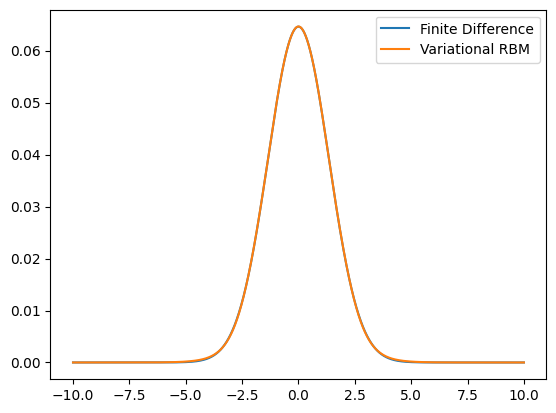

In [49]:
T = np.zeros((len(alphaVals),m)) 

#Getting high-fidelity solutions
for i,alpha in enumerate(alphaVals):
    fdSolver = FiniteDifferenceSolver(alpha,grid,h)
    evals, evecs, runTime = fdSolver.solve()
    T[i] = evecs[:,n]

fig, ax = plt.subplots()

alphaTest = 0.3

exactEigenvalue = 2*exact_eigenvalue(n,alphaTest)

#Solving with finite difference
fdSol = FiniteDifferenceSolver(alphaTest,grid,h)
t0 = time.time()
evals, evecs, _ = fdSol.solve()
t1 = time.time()
print('Finite Difference time: %.3e s'%(t1-t0))

err = abs(((evals[0]-exactEigenvalue)/exactEigenvalue))
print('Finite Difference relative error: %.3e'%err)

ax.plot(grid,evecs[:,0],label='Finite Difference')

#Solving with variational RBM
rbm = VariationalRBM(T,h,grid)
a0 = np.ones(len(alphaVals))
t0 = time.time()
for _ in range(nRepeatsForTiming):
    eigenvalue, a = rbm.solve(alphaTest,a0)
t1 = time.time()

wf = rbm.return_wf(a)

runTime = (t1-t0)/nRepeatsForTiming
print('Standard RBM time: %.3e s'%runTime)
print('RBM relative error: %.3e'%((val-exactEigenvalue)/exactEigenvalue))

ax.plot(grid,wf,label='Variational RBM')

ax.legend()

### Inferring the Reduced Hamiltonian
All of the above is fantastic: it speeds up the code versus a standard finite difference solver, without losing basically any accuracy. But, we are always required to compute overlaps of the form

\begin{align}
M_{ij}(\alpha)\equiv \langle\psi_j|H_\alpha|\phi_i\rangle,
\end{align}

in a manner that is $\mathcal{O}(n)$ without much accuracy loss. Even for problems in which the parameter(s) appear in an affine manner (such as the HO), this can be time-consuming, especially given many parameters in the problem. It is even worse when parameters are not affine, and so to apply this to any particular problem uses a lot of development time thinking about implementation details.

One work-around is to attempt to infer a simple form of $M(\alpha)$, say, $\hat{M}(\alpha)$, just based on the overlaps themselves. As an example, suppose we assume a quadratic polynomial in $\alpha$,

\begin{align}
\hat{M}(\alpha)\equiv M^{(0)}+\alpha M^{(1)}+\alpha^2M^{(2)}.
\end{align}

We can use our high-fidelity solutions $\{\phi_i\}$ and judges $\{\psi_i\}$, compute the overlaps $M_{ij}(\alpha_k)$ for $\alpha_k=\alpha_1,\ldots,\alpha_n$, and fit the coefficients of $\hat{M}$ such that

\begin{align}
\hat{M}(\alpha_k)\approx M(\alpha_k),\quad k=1,\ldots,n.
\end{align}

This can be done coefficient-by-coefficient, to minimize the residual

\begin{align}
\sum_{k=1}^n[\hat{M}_{ij}(\alpha_k)-M_{ij}(\alpha_k)]^2.
\end{align}

No longer do you have to attempt to make the division made above (although it is simpler for the HO). 

For affine parameters, the form of $\hat{M}$ can be chosen to be affine as well; for others, literally any parametric form is allowed. One option, if you really don't know what to choose, is to take a parametric form with many terms, but solve a sparse optimization problem for the coefficients instead [CITE SOMETHING]. And, this is not too tricky to generalize for multiple parameters (although choosing the form is still somewhat up-in-the-air).

This is implemented for the HO below, with just a linear polynomial in $\alpha$. Since we know the correct form already, this example can be taken as guidance if you wish to apply it to your own problem. And, it can be extended to non-eigenvalue problems in the same way "traditional" RBM approaches have been.

In [50]:
class InferHamiltonian:
    def __init__(self,psiMat,arrOfHamiltonians,alphaVals,judges=None):
        self.psiMat = psiMat
        if judges is None:
            self.judges = psiMat
        else:
            self.judges = judges
        self.arrOfHamiltonians = arrOfHamiltonians
        self.alphaVals = alphaVals
        self.matrixDim = len(alphaVals)
        
        self.projections = self.compute_projections()
        self.overlaps = self.compute_overlaps()
        
    def compute_projections(self):
        projections = np.zeros(3*(self.matrixDim,))
        for k in range(self.matrixDim):
            for i in range(self.matrixDim):
                for j in range(i,self.matrixDim):
                    projections[k,i,j] = self.judges[i] @ self.arrOfHamiltonians[k] @ self.psiMat[j]
                    projections[k,j,i] = projections[k,i,j]
                    
        return projections
    
    def compute_overlaps(self):
        overlapMatrix = np.zeros(2*(self.matrixDim,))
        for i in range(self.matrixDim):
            for j in range(i,self.matrixDim):
                overlapMatrix[i,j] = self.judges[i] @ self.psiMat[j]
                overlapMatrix[j,i] = overlapMatrix[i,j]
        return overlapMatrix
    
    def fit_matrices(self,polyDegree=1):
        #Note that minCoeffs is indexed backwards - the first element is
        #the coefficient of the highest degree term in the polynomial
        minCoeffs = np.zeros((polyDegree+1,self.matrixDim,self.matrixDim,),)
        for i in range(self.matrixDim):
            for j in range(i,self.matrixDim):
                minCoeffs[:,i,j] = np.polyfit(self.alphaVals,
                                              self.projections[:,i,j],
                                              polyDegree)
                minCoeffs[:,j,i] = minCoeffs[:,i,j]
        return minCoeffs
        
    def return_wf(self,a):
        return a @ self.psiMat / np.linalg.norm(a @ self.psiMat)

    def solve(self,alpha,coeffs):
        mat = np.zeros(2*(self.matrixDim,))
        maxPolyDim = coeffs.shape[0] - 1
        for (coeffIter,coeff) in enumerate(coeffs):
            mat += alpha**(maxPolyDim - coeffIter) * coeff
            
        vals, vecs = eigh(mat,b=self.overlaps,check_finite=False)
        
        return vals[0], vecs[:,0]

Finite Difference time: 1.405e+00 s
Finite Difference relative error: 3.423e-06
Inferred Matrix time: 2.962e-05 s
Relative error: 7.248e-05


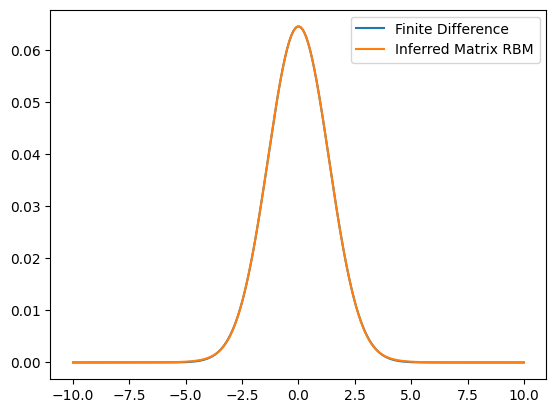

In [51]:
T = np.zeros((len(alphaVals),m)) 

#Getting high-fidelity solutions - note that we save the Hamiltonians for this case
listOfHamiltonians = []

for i,alpha in enumerate(alphaVals):
    fdSolver = FiniteDifferenceSolver(alpha,grid,h)
    evals, evecs, runTime = fdSolver.solve()
    listOfHamiltonians.append(fdSolver.make_Hamiltonian_matrix())
    T[i] = evecs[:,n]

fig, ax = plt.subplots()

alphaTest = 0.3

exactEigenvalue = 2*exact_eigenvalue(n,alphaTest)

#Solving with finite difference
fdSol = FiniteDifferenceSolver(alphaTest,grid,h)
t0 = time.time()
evals, evecs, _ = fdSol.solve()
t1 = time.time()
print('Finite Difference time: %.3e s'%(t1-t0))

err = abs(((evals[0]-exactEigenvalue)/exactEigenvalue))
print('Finite Difference relative error: %.3e'%err)

ax.plot(grid,evecs[:,0],label='Finite Difference')

#Solving with RBM
inferObj = InferHamiltonian(T,listOfHamiltonians,alphaVals)
coeffs = inferObj.fit_matrices()
t0 = time.time()
for _ in range(nRepeatsForTiming):
    val, a = inferObj.solve(alphaTest,coeffs)
t1 = time.time()

wf = inferObj.return_wf(a)

runTime = (t1-t0)/nRepeatsForTiming
# ax.plot(grid,wf,label='Infer Matrix',ls=':')
print('Inferred Matrix time: %.3e s'%runTime)
print('Relative error: %.3e'%((val-exactEigenvalue)/exactEigenvalue))

ax.plot(grid,wf,label='Inferred Matrix RBM')

ax.legend()

### The CAT Plot

There are many concerns when choosing which method to use to solve your problem. While there are many considerations, including development time, one useful diagnostic tool is the so-called CAT plot, which shows the accuracy vs run time of your method. This is created below for the methods described above. For each method, the run time is averaged over multiple runs. Additionally, multiple different sets of training solutions are used. 

As can be seen, including more $\alpha$ values improves performance, with little runtime increase, almost up to the high-fidelity solution's performance. Additionally, it is clear that the finite difference solver is incredibly slow relative to other methods, and even the variational RBM fails to compete with the standard RBM case.

Finite Difference time: 1.517e+00 s
Relative error: 3.423e-06
Standard RBM time: 2.429e-05 s
Relative error: 5.696e-03
Variational RBM time: 3.582e-03 s
Relative error: 5.696e-03
Inferred Matrix time: 2.674e-05 s
Relative error: 5.696e-03
Standard RBM time: 3.953e-05 s
Relative error: 1.292e-03
Variational RBM time: 7.733e-03 s
Relative error: 1.292e-03
Inferred Matrix time: 2.964e-05 s
Relative error: 1.292e-03
Standard RBM time: 2.088e-05 s
Relative error: 8.799e-04
Variational RBM time: 6.159e-03 s
Relative error: 1.647e-03
Inferred Matrix time: 2.804e-05 s
Relative error: 8.799e-04
Standard RBM time: 2.809e-05 s
Relative error: 7.248e-05
Variational RBM time: 7.077e-03 s
Relative error: 1.441e-04
Inferred Matrix time: 2.958e-05 s
Relative error: 7.248e-05


[None,
 None,
 Text(0.5, 0, 'Time (s)'),
 Text(0, 0.5, 'Eigenvalue Relative Error'),
 (1e-05, 10),
 (1e-06, 0.1)]

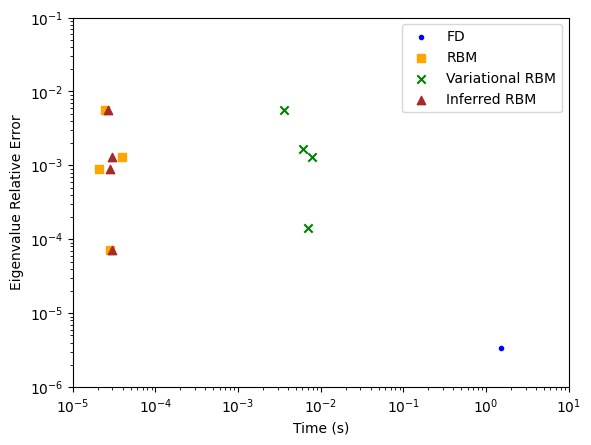

In [54]:
catFig, catAx = plt.subplots()

alphaValsList = [[0.5,5,10,15],
                 [0.5,2,5,10,15],
                 [0.5,2,5,10,15,25],
                 [0.1,0.5,2,5,10,15,25]]

alphaTest = 0.3

exactEigenvalue = 2*exact_eigenvalue(n,alphaTest)

#Independent of alphaVals, so only do this once
fdSol = FiniteDifferenceSolver(alphaTest,grid,h)
t0 = time.time()
evals, evecs, _ = fdSol.solve()
t1 = time.time()
print('Finite Difference time: %.3e s'%(t1-t0))
err = abs(((evals[0]-exactEigenvalue)/exactEigenvalue))
print('Relative error: %.3e'%err)
catAx.scatter(t1-t0,err,color='blue',
              marker='.',label='FD')

for (alphaIter,alphaVals) in enumerate(alphaValsList):
    T = np.zeros((len(alphaVals),m)) 
    
    listOfHamiltonians = []
    
    for i,alpha in enumerate(alphaVals):
        fdSolver = FiniteDifferenceSolver(alpha,grid,h)
        evals, evecs, runTime = fdSolver.solve()
        listOfHamiltonians.append(fdSolver.make_Hamiltonian_matrix())
        kinTerm = fdSolver.make_kinetic_term()
        potTerm = fdSolver.make_potential_term()/alpha
        T[i] = evecs[:,n]
    
    rbm = StandardRBM(T,kinTerm,potTerm)
    t0 = time.time()
    for _ in range(nRepeatsForTiming):
        val, a = rbm.solve(alphaTest)
    t1 = time.time()
    runTime = (t1-t0)/nRepeatsForTiming
    print('Standard RBM time: %.3e s'%runTime)
    print('Relative error: %.3e'%((val-exactEigenvalue)/exactEigenvalue))
    
    catAx.scatter(runTime,(val-exactEigenvalue)/exactEigenvalue,color='orange',
                  marker='s',label='RBM')
    
    rbm = VariationalRBM(T,h,grid)
    a0 = np.ones(len(alphaVals))
    t0 = time.time()
    for _ in range(nRepeatsForTiming):
        eigenvalue, a = rbm.solve(alphaTest,a0)
    t1 = time.time()
    runTime = (t1-t0)/nRepeatsForTiming
    print('Variational RBM time: %.3e s'%runTime)
    print('Relative error: %.3e'%((eigenvalue-exactEigenvalue)/exactEigenvalue))
    
    catAx.scatter(runTime,(eigenvalue-exactEigenvalue)/exactEigenvalue,color='green',
                  marker='x',label='Variational RBM')
    
    inferObj = InferHamiltonian(T,listOfHamiltonians,alphaVals)
    coeffs = inferObj.fit_matrices()
    t0 = time.time()
    for _ in range(nRepeatsForTiming):
        val, a = inferObj.solve(alphaTest,coeffs)
    t1 = time.time()
    runTime = (t1-t0)/nRepeatsForTiming
    print('Inferred Matrix time: %.3e s'%runTime)
    print('Relative error: %.3e'%((val-exactEigenvalue)/exactEigenvalue))
    
    catAx.scatter(runTime,(val-exactEigenvalue)/exactEigenvalue,color='brown',
                  marker='^',label='Inferred RBM')
    
    if alphaIter == 0:
        catAx.legend()

catAx.set(xscale='log',yscale='log',
          xlabel='Time (s)',ylabel='Eigenvalue Relative Error',
          xlim=(10**(-5),10**1),ylim=(10**(-6),10**(-1)))

### Final Remarks

If you look closely, nowhere in this code have I used the principal components of a set of solutions. While it may help, it is not strictly necessary for any of this. Additionally, the code has been implemented such that one can use any judges desired - again, while it works well to use the high-fidelity solutions as judges, that is not strictly necessary, and is worth exploring on a problem-by-problem basis.